In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
!pip install stldecompose
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import json
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [3]:
file_name = 'crypto_data_2.csv'
df = pd.read_csv(file_name)
print(len(df))

#df['date'] = pd.to_datetime(df['date'])



df.index = range(len(df))


df.dropna(subset=['close'], inplace=True)
df.reset_index(drop=True)

df.isnull().values.any()

df.head()


22545


,date,high,low,open,close,volume,adjclose,coin,formatted_date
0,1483228800,1003.080017,958.698975,963.658020,0.965275,147775008.0,998.325012,BTC-USD,1/1/19
1,1483315200,1031.390015,996.702026,998.617004,0.977359,222184992.0,1021.750000,BTC-USD,1/2/19
2,1483401600,1044.079956,1021.599976,1021.599976,0.978694,185168000.0,1043.839966,BTC-USD,1/3/19
3,1483488000,1159.420044,1044.400024,1044.400024,0.904454,344945984.0,1154.729980,BTC-USD,1/4/19
4,1483574400,1191.099976,910.416992,1156.729980,1.141457,510199008.0,1013.380005,BTC-USD,1/5/19


In [4]:
df.head()

,date,high,low,open,close,volume,adjclose,coin,formatted_date
0,1483228800,1003.080017,958.698975,963.658020,0.965275,147775008.0,998.325012,BTC-USD,1/1/19
1,1483315200,1031.390015,996.702026,998.617004,0.977359,222184992.0,1021.750000,BTC-USD,1/2/19
2,1483401600,1044.079956,1021.599976,1021.599976,0.978694,185168000.0,1043.839966,BTC-USD,1/3/19
3,1483488000,1159.420044,1044.400024,1044.400024,0.904454,344945984.0,1154.729980,BTC-USD,1/4/19
4,1483574400,1191.099976,910.416992,1156.729980,1.141457,510199008.0,1013.380005,BTC-USD,1/5/19


In [5]:
df['EMA_9'] = df['close'].ewm(9).mean().shift()
df['SMA_5'] = df['close'].rolling(5).mean().shift()
df['SMA_10'] = df['close'].rolling(10).mean().shift()
df['SMA_15'] = df['close'].rolling(15).mean().shift()
df['SMA_30'] = df['close'].rolling(30).mean().shift()

df.isnull().values.any()


True

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.formatted_date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.formatted_date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.formatted_date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.formatted_date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.formatted_date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.formatted_date, y=df.close, name='Close', opacity=0.2))
fig.show(renderer="colab")

In [7]:
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

In [8]:
test_size  = 0.15
valid_size = 0.15


coins=[]
coin = ''
for i in range(len(df.coin)):
  temp = df.coin[i]
  if temp != coin:
    coins.append(temp)
  coin = temp
print(coins)

count = 0
train_df = pd.DataFrame()
test_df = pd.DataFrame()
valid_df = pd.DataFrame()

print(df.shape[0])
start_idx = 0
for coin in coins:
  num_rows = df[df.coin == coin].shape[0]

  
  test_split_idx  = int(count + num_rows * (1-test_size))
  valid_split_idx = int(count + num_rows * (1-(valid_size+test_size))) 
  end_idx = start_idx + num_rows


  #print(test_split_idx, valid_split_idx)

  train_df = train_df.append(df.loc[start_idx:valid_split_idx].copy()) 
  valid_df  = valid_df.append(df.loc[valid_split_idx+1:test_split_idx].copy())
  test_df = test_df.append(df.loc[test_split_idx+1:end_idx].copy())



  count+=num_rows
  start_idx = end_idx+1

print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)


'''
print(df[df.coin == 'BTC-USD'].shape[0])
test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()
'''




['BTC-USD', 'ETH-USD', 'SOL1-USD', 'BNB-USD', 'DOT1-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'SHIB-USD', 'AVAX-USD', 'LTC-USD', 'XMR-USD', 'ETC-USD', 'REP-USD', 'MAID-USD', 'STEEM-USD']
22545
(15667, 17)
(3492, 17)
(3386, 17)


"\nprint(df[df.coin == 'BTC-USD'].shape[0])\ntest_split_idx  = int(df.shape[0] * (1-test_size))\nvalid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))\n\ntrain_df  = df.loc[:valid_split_idx].copy()\nvalid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()\ntest_df   = df.loc[test_split_idx+1:].copy()\n"

In [9]:

drop_cols = ['date', 'volume', 'open', 'low', 'high', 'adjclose', 'formatted_date', 'coin']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

test_df['close'].values

array([1.02548869, 0.95800357, 1.04038487, ..., 1.01664318, 1.03592342,
       0.94608251])

In [16]:
y_train = train_df['close'].copy().values
X_train = train_df.drop(['close'], 1).values

y_train = (y_train- y_train.mean()) / y_train.std() 

y_valid = valid_df['close'].copy().values
X_valid = valid_df.drop(['close'], 1).values

y_valid = (y_valid- y_valid.mean()) / y_valid.std() 


print(test_df['close'])
y_test  = test_df['close'].copy().values
X_test  = test_df.drop(['close'], 1).values

y_test = (y_test- y_test.mean()) / y_test.std() 


print(y_train.max())
print(y_test.max())
print(y_valid.max())
print(df['close'].max())
#X_train.info()

1517     1.025489
1518     0.958004
1519     1.040385
1520     0.991819
1521     0.999731
           ...   
22540    0.981075
22541    0.962636
22542    1.016643
22543    1.035923
22544    0.946083
Name: close, Length: 3492, dtype: float64
13.136576207093201
10.37024087240824
11.74747427054399
1.9112960509999999


In [17]:
parameters = {
    'n_estimators': [300, 400],
    'learning_rate': [0.01, 0.05],
    'max_depth': [8, 10],
    'gamma': [0.01, 0.05],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

df.dropna(inplace=True)

from sklearn import preprocessing
X_train = preprocessing.scale(X_train) 

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.7725062108138641


In [18]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 13.8 s, sys: 24 ms, total: 13.8 s
Wall time: 13.8 s


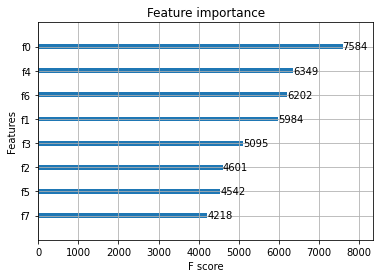

In [19]:
plot_importance(model);

In [20]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')


y_true = [ 0.32977395 -0.57091999  0.52858667 -0.11960024 -0.01400114]
y_pred = [0.07003421 0.06486595 0.09471104 0.09246564 0.10058096]


In [21]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')


mean_squared_error = 0.9931355532720186


# New Section